# Random numbers

Random numbers play a surprisingly central role in many areas of physics, and life in general.

They are used in cryptography, which is necessary for securing communications, on-line banking, crypto-currencies (e.g., bitcoin), and so on. You might think that the security of on-line communications is not super-critical, but without it it is possible for eavesdropping computers to intercept your communications and alter them before passing them on. In physics, random numbers are very useful for so-called Monte-Carlo computer simulations, where you generate fake - but realistic - data for testing hypotheses.

So, we need a source of truly random numbers. All you need is a random sequence of binary 1's and 0's - this is sufficient to generate any randomness you need (e.g, a 32-bit number, a floating point number to a certain precision, and so on).

The problem is that perfect randomness is impossible to achieve. You can get close by using observations of a natural phenomenon such as radiative decay, or a noise source, but there are always going to be observational biases that can subtly affect the results.

## Linear conguential random number generators

There are various algorithmic techniques for generating pseudo-random numbers. One of the best known are the linear congruential random number generators that we explored in one of the homework exercises. Here is how we generate the next random number in such a sequence:

$$X_{n+1}=(aX_n+c)\,\,{\rm mod}\,\,m$$

Where $m$ is the modulus, $a$ is the multiplier, and $c$ is the increment. These constants have to be chosen carefully, and [wikipedia will show you a table](https://en.wikipedia.org/wiki/Linear_congruential_generator) of 20 or so choices that various software libraries use. For example, the GNU C library uses $m=2^{31}-1, a=1103515245,$ and $c=12345$. 

The linear congruential generators produce random numbers between 0 and $m-1$. They have the advantages of being very quick to calculate, giving a reasonable degree of randomness, and being absolutely predictable given an initial seed of $X_0$. This last advantage is useful if you want to exactly reproduce the result of a calculation. However, it is a disadvantage if you want your sequence of random numbers to be unpredictable. Programmers will often generate a seed by using the current time to nanosecond precision, but this is a risky thing to do if you are worried about someone being able to guess your numbers.

## The Mersenne Twister random number generator

This is based on an algorithm developed by two Japanese researchers in 1997, and is very widely used (e.g., Python uses it). See [its wikipedia page](https://en.wikipedia.org/wiki/Mersenne_Twister) for a description of how it works.

A disadvantage of this PRNG (psuedo-random number generator), and the linear congruential one we discussed above, is that they are not *crytographically secure*, i.e., although the sequence of numbers is nicely random, if you observe a sufficiently long sequence (just 624 numbers in the case of the Mersenne Twister) then you can predict all future iterations. There are also various subtle issues that you should be aware of, e.g., if you want to use different seeds to generate distinct sets of random numbers, and with the time it takes for the sequence to randomise when starting from seeds with lots of zeroes.

## Sources of randomness available from the Linux OS

Linux computers have a file called `/dev/random` that, if you read it, will give you an endless stream of 8-bit (i.e., from 0 to 255) random numbers. You can print out the binary digits in this file using

```
cat /dev/random | perl -n -e "print unpack 'B*';"
```

Note that due to buffering of data, the above command will output 4096 bits at a time. Aside: for those interested in the details, the above command uses the `cat` program to read `/dev/random`, and the resultant bytes are "piped" with the `|` command to a program written in the `perl` programming language; the program is simply the instruction to convert each byte to a series of bits and display the result.

While the file is endless, the rate at which new bytes (8-bit numbers) are produced is limited by the sources of entropy (randomness) that are available to the operating system (OS) - in a test I did while writing this, it took about 15 minutes after freshly booting Linux to generate 4096 random bits. Linux makes use of things such as mouse movements, keyboard activity, network activity, timing of computer interrupts, and possibly hardware random number generators. You might find that the rate of new bytes from `/dev/random` is too slow for your application, in which case you could try `/dev/urandom`, which uses a pseudo-random number generator seeded by `/dev/random` to continue to provide numbers even when entropy from the environment has run out. It is widely regarded as a very good source of random numbers.

## Internet-based RNGs

[There are](http://www.random.org) RNGs that you can access on the internet. While they may be very good, you should use them at your own risk.

## Testing random generators

There are programs available to test whether a given list of random numbers satisfy various tests of randomness. E.g., the [DieHarder suite](https://en.wikipedia.org/wiki/Diehard_tests) of tests from Robert Brown at Duke University.

A simple test for randomness is to generate a file of random numbers and then try *compressing* the file (i.e., making the file smaller) using a program such as gzip, bzip2, or 7z. Truly random numbers don't have any patterns, and hence can not be compressed. So, if the output file from an attempt at compression is *larger* than the original, then this gives some degree of confidence that the numbers are random.

As an experiment, I took 4096 bits from `/dev/random` and compressed then with gzip and bzip2. gzip "compressed" the file to 5960 bits, and bzip2 to 6008 bits. In a longer test, a random file of 26,345,472 bytes was "compressed" to 26,349,514 by gzip, and 26,461,061 by bzip2. The fact that the original files couldn't be compressed to a smaller size is an indication of their randomness.

Visual tests of random number generators can sometimes make faults obvious. For example, the following images were generating by assigning each pixel to be black or white depending on a random number generator, with the sequence following a raster pattern. The first image was created with random numbers from http://www.random.org, the second is from the PHP computer language running on Windows in 2008. There are clearly problems with the latter.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/randbitmap-rdo.png)

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/randbitmap-wamp.png)


## Example: generating a 16-bit ID upon first boot of an ATtiny-85.

![](http://mcba11.phys.unsw.edu.au/~mcba/20160908_121516.jpg)

The ATtiny-85 is an 8-bit microcontroller the size of your little fingernail that is a very useful building block for all sorts of scientific instruments. I'm using hundreds of these devices to control the battery packs for my astronomical experiments in Antarctica - the image above shows one of the printed circuit boards that I use; the ATtiny-85 is the black 8-pin component labelled U1 at lower centre. 

One issue I faced is that I wanted the software running on each ATtiny-85 to have its own unique 16-bit serial number, but I didn't want to have to individually program each one with a different number, since that is time consuming to do. Initially, each device is programmed with an identical "bootstrap" program, which allows the longer application program to be loaded at a later time using an infrared receiver (U2 in the image above) attached to the ATtiny-85. As part of the bootstrap process I wanted each device to generate a random 16-bit ID, which it would store in its on-board non-volatile memory, and which would then be used as an address for all subsequent communication with the device.

This is an interesting problem. All ATtiny-85s are nominally identical (e.g., unlike some microprocessors they don't have an inbuilt serial number), which would make it impossible to generate a random number that differed from device to device. However, on closer inspection there are some differences. E.g., the ATtiny-85 has an internal RC (resistor-capacitor) oscillator that sets its cycle-time, and to calibrate this to within a few percent, the manufacturer loads a special 8-bit register in the ATtiny-85 with a number that is used by the oscillator division circuitry. This number does vary from device to device, although at the best you would get an 8-bit random number by using it, and more likely you would reliably have only a bit (e.g., it could be that the manufacturing tolerance was very high, and most of the devices had the same calibration number).

Even closer inspection reveals that the ATtiny-85 has two independent RC oscillators in it (one is used for high speed normal operation, the other operates a "watchdog timer" that allows the device to go into low-power mode), and that they drift in different directions with temperature and voltage. By comparing these two oscillators it would be possible to generate random numbers. For example, you could count the number of oscillations of the high speed oscillator in a fixed number of low-speed clock cycles. Provided that you made the observation time long enough, the least-significant bit of the count is likely to be quite random. But you might have to wait minutes to generate 16-bits of randomness.

Further inspection of the datasheet for the ATtiny-85 reveals that it has an internal temperature sensor, and an analog-to-digital converter. The temperature sensor has fairly poor resolution (about a degree C), and is not very accurate (which is good from a randomness point-of-view), but probably adds only a bit of entropy. The ADC could be used to measure some external voltage, but this is also unlikely to add more than a bit of entropy unless a cleverly designed circuit is used.

In the end, I used the fact that my ATtiny-85s are all connected to infrared receivers, and I can time the interval between pulses on the infrared receivers to microsecond precision (as measured by the fairly inaccurate internal clock). I used the least significant bit of each interval to generate a single bit of randomness, so I only required 16 transitions of the infrared receiver to derive the 16-bit device ID. Even if all of the ATtiny-85s are observing the same infrared signals, there is enough variation in the trigger points of the infrared receivers, and in the frequency of the internal clocks, that the odd/even-ness of the microsecond timing is highly random. 

Now 16-bits gives a total of 65536 IDs, and I needed to allocate one ID to indicate "ID not yet determined", leaving 65535 possibilities. There is a chance that two devices would arrive at the same ID, and I solved this by simply reinitialising a device in this unlikely case.

[A movie showing the battery management system in action](http://mcba11.phys.unsw.edu.au/~mcba/20160912_1301011.mp4). The infrared signals are at a wavelength of 950 nm, which is visible to most phone cameras. In this movie you see the infrared transmitters communicating in sequence to a master controller. There is a lot of cunning software going on in this movie, e.g., the devices have to know when to transmit so that they don't overlap with other communication. 

## Generating randomness on bootup

The example above with the ATtiny-85 might sound artificial, and a niche application, but it is actually very similar to what all modern computers (down to the level of any internet-connected device) have to do when they first start up. Any networked device has to be able to generate random numbers in order to be able to communicate securely. There are [numerous examples](https://en.wikipedia.org/wiki/Random_number_generator_attack) of poor, predictable, random number generators leading to security problems.

## Random numbers in Python

Python provides a wealth of random number functions that will satisfy almost all the needs of a physicist.

Our first example program generates 100 random bytes, and prints out the result as 800 random bits (since a byte, encoding numbers from 0 to 255, consists of 8 bits).

In [2]:
import numpy as np

# Ask numpy for 100 random bytes.

b = np.random.bytes(100)

# For printing purposes, let's convert these to bits.

bb = np.unpackbits(bytearray(b))
print(bb)

[0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1
 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1
 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0
 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1
 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0
 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0
 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 1 0 1 

Our next example uses numpy routines to generate random integers, and random floating-point numbers. 

In [3]:
import numpy as np

# Generate 100 random integers between 0 and 9.

ri = np.random.randint(10, size=100)
print(ri)

# Generate 100 random floating-point numbers between 0 and 1.

rf = np.random.random(100)
print(rf)

[5 8 8 7 4 1 4 9 6 6 1 6 6 9 2 3 9 0 4 2 6 6 3 4 7 5 6 5 9 1 7 3 0 7 5 2 1
 0 6 8 6 2 5 2 4 3 2 0 7 1 8 8 2 6 2 5 6 1 6 1 9 8 2 5 6 2 8 9 9 9 0 5 7 7
 6 2 5 0 3 2 3 5 0 4 7 3 4 6 2 8 9 2 9 1 2 7 8 2 6 4]
[0.74200368 0.67844948 0.90326692 0.69378894 0.32557142 0.25426902
 0.08463902 0.9311793  0.19139087 0.41548894 0.69866709 0.21174978
 0.18803835 0.57811887 0.71486666 0.36016152 0.5914645  0.97520349
 0.00944008 0.84773737 0.72581088 0.84687944 0.73384478 0.43337959
 0.63688969 0.70052883 0.63345847 0.08056424 0.53906194 0.30439054
 0.43703172 0.96574872 0.9337184  0.88471839 0.64020914 0.7594347
 0.89702385 0.94080828 0.35701038 0.18084075 0.06985745 0.33974213
 0.57622321 0.1182964  0.36017249 0.35342792 0.19744297 0.30284217
 0.87249519 0.09151235 0.52173355 0.73772825 0.38031995 0.94339181
 0.3797895  0.55070362 0.95003669 0.62419236 0.5394387  0.97103302
 0.13563386 0.00813237 0.05492445 0.43696492 0.05507486 0.47206267
 0.86472126 0.13231767 0.33545997 0.93443897 0.88822172 0.62

numpy makes it easy to generate random numbers that follow various distributions (e.g., gaussian, poisson, binomial). Let's generate some and plot histograms of the distributions to see how they look.

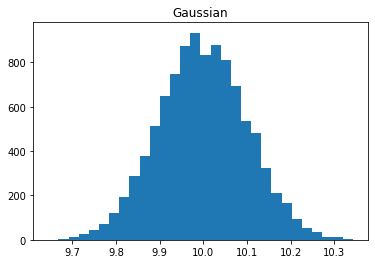

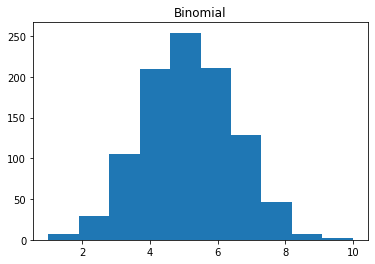

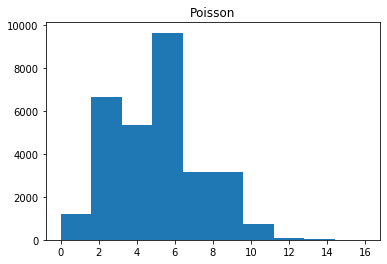

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Generate 100 random numbers from a normal (Gaussian) distribution
# with mean 10.0 and standard deviation 0.1.

rn = np.random.normal(loc=10.0, scale=0.1, size=10000)

# Print them, or plot as a histogram.

#print(rn)
plt.hist(rn, bins=30)
plt.title("Gaussian")
plt.show()

# Now try a binomial distribution.

rb = np.random.binomial(n=10, p=0.5, size=1000)
plt.hist(rb)
plt.title("Binomial")
plt.show()

# And a poisson distribution.

rp = np.random.poisson(lam=5, size=30000)
plt.hist(rp)
plt.title("Poisson")
plt.show()

## Cryptographically secure random numbers

Cryptographically secure random numbers are ones which aren't the result of an algorithm, and so their future behaviour can not be guessed by observing a sufficiently long sequence.

In [5]:
import os
import numpy

# Call the OS for its best random numbers. Versions of
# Python from 3.6 up have a "secrets" module for accessing this RNG.

b = os.urandom(10)
print(np.unpackbits(bytearray(b)))

[0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1
 1 0 1 0 1 1]


In [6]:
import secrets
import numpy

# This works with Python version from 3.6 up.

b = secrets.token_bytes(10)
print(np.unpackbits(bytearray(b)))

[1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0
 1 0 1 1 1 0]


## The Intel hardware random number generator

Intel CPUs since at least 2015 have provided an assembly language instruction called RDRAND that returns random numbers, seeded by a hardware source of noise. Operating system developers have been reluctant to use this instruction, since they are worried about possible security backdoors inserted into the CPU by certain 3-letter government agencies.